In [1]:
from thesispy.experiments.wandb_client import *
from thesispy.experiments.validation import VALIDATION_NAMES_NEW, VALIDATION_ABBRVS_NEW
from thesispy.experiments.wandb_client import get_runs_as_dataset
from thesispy.experiments.validation import *
from thesispy.plot_utils import *
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy.stats import ttest_ind

In [2]:
ds = get_runs_as_dataset("synthetic_1_linkage_models", {"config.StaticLinkageMaxSetSize": {"$in": [12, 24]}})
arrs = ds.aggregate_for_plot(["FosElementSize", "MeshSize"])

In [5]:
mean_runtimes = {}
std_runtimes = {}

for group, runs in ds.groupby(["FosElementSize", "MeshSize"]):
    mean_runtimes[group] = np.mean([run.summary["_runtime"] for run in runs])
    std_runtimes[group] = 0.2 * np.std([run.summary["_runtime"] for run in runs])

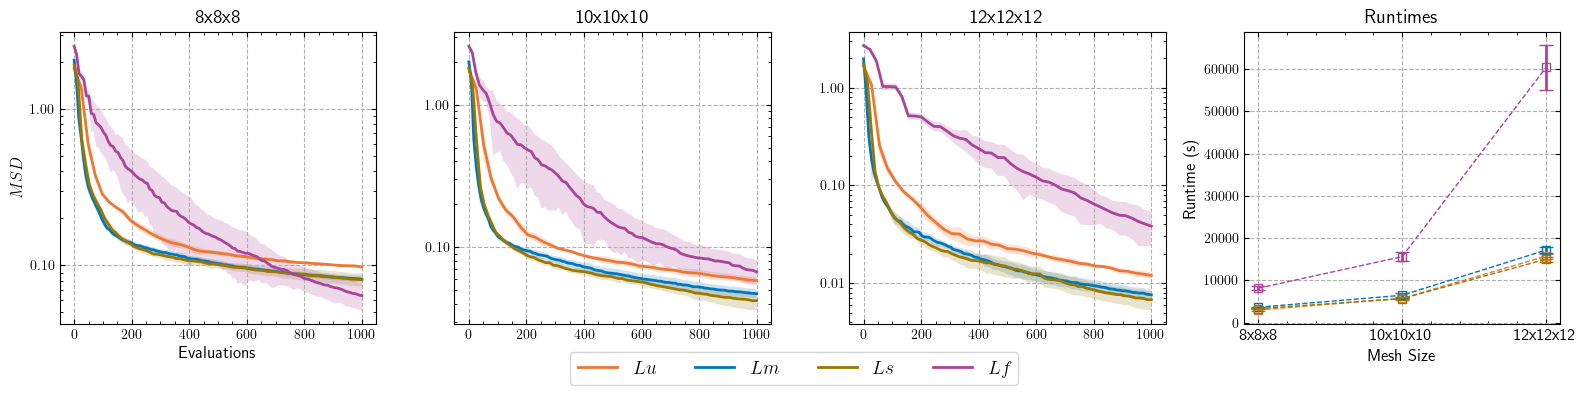

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

labels = {
    1: "$Lu$",
    -6: "$Lm$",
    -3: "$Ls$",
    -1: "$Lf$"
}

run_times = []

for fos_size in [1, -6, -3, -1]:
    mean_runtimes_ = []
    std_runtimes_ = []

    for i, mesh_size in enumerate([(5, 5, 5), (7, 7, 7), (9, 9, 9)]):
        arr_avg, arr_median, arr_std = arrs[(fos_size, mesh_size)]
        xs = np.linspace(0, 1000, len(arr_median))
        axes[i].plot(xs, arr_median, label=labels[fos_size])
        axes[i].fill_between(xs, arr_median - arr_std, arr_median + arr_std, alpha=0.2)
        
        # formatting
        axes[i].set_yscale("log")
        axes[i].yaxis.set_major_formatter(ScalarFormatter())
        axes[i].set_title(mesh_size_as_str(mesh_size), loc="center", fontsize=14)

        mean_runtimes_.append(mean_runtimes[(fos_size, mesh_size)])
        std_runtimes_.append(std_runtimes[(fos_size, mesh_size)])
    
    axes[3].errorbar(
                    [1, 2, 3],
                    mean_runtimes_,
                    yerr=std_runtimes_,
                    fmt="--s",
                    markerfacecolor='none',
                    label=labels[fos_size],
                    capsize=5,
                    capthick=1,
                    elinewidth=2,
                    markersize=6,
                    linewidth=1
    )


axes[3].set_xticks([1, 2, 3], ["8x8x8", "10x10x10", "12x12x12"], fontsize=12)
axes[3].set_xlabel("Mesh Size", fontsize=12)
axes[3].set_ylabel("Runtime (s)", fontsize=12)
axes[3].set_title("Runtimes", loc="center", fontsize=14)

axes[0].set_xlabel("Evaluations", fontsize=12)
axes[0].set_ylabel("$MSD$", fontsize=12)
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, ncol=4, loc="lower center", prop={'size': 14})

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig("subplots_metric_runtimes.pdf")

In [5]:
df = ds.aggregate(["FosElementSize", "MeshSize"], metrics=VALIDATION_NAMES_NEW, val=True)

In [18]:
from tabulate import tabulate

rows = []
mesh_size = "(5, 5, 5)"

for n, metric in enumerate(VALIDATION_NAMES_NEW):
    row = []
    row.append(VALIDATION_ABBRVS_NEW[n])

    dfs = []
    
    for i, fos_size in enumerate([1, -6, -3, -1]):
        df_fos = df.loc[(df.MeshSize == mesh_size) & (df.FosElementSize == str(fos_size))][metric]
        dfs.append(df_fos)

        avg = df_fos.mean()
        std = df_fos.std()

        row.append(f"{avg:.2f} $\pm$ {std:.2f}")

    best_index = None
    for f_i, a in enumerate(dfs):
        best = True
        for f_ib, b in enumerate(dfs):
            if f_i == f_ib:
                continue
            t, p = ttest_ind(a, b)
            if p > 0.05 or a.mean() >= b.mean():
                best = False
                break
        if best:
            best_index = f_i + 1
            break
    
    if best_index is not None:
        row[best_index] = "\\textbf{" + row[best_index] + "}"    

    rows.append(row)

print(tabulate(rows, headers=["placeholder"]*13, tablefmt="latex_raw"))

\begin{tabular}{lllll}
\hline
 placeholder             & placeholder     & placeholder              & placeholder              & placeholder     \\
\hline
 $TRE$                   & 1.81 $\pm$ 0.03 & \textbf{1.45 $\pm$ 0.09} & 1.64 $\pm$ 0.17          & 3.31 $\pm$ 0.31 \\
 $ASD_{\textsc{cube}}$   & 0.64 $\pm$ 0.01 & 0.49 $\pm$ 0.02          & 0.49 $\pm$ 0.01          & 0.74 $\pm$ 0.03 \\
 $ASD_{\textsc{sphere}}$ & 0.29 $\pm$ 0.01 & 0.28 $\pm$ 0.01          & 0.27 $\pm$ 0.01          & 0.46 $\pm$ 0.04 \\
 $HD_{\textsc{cube}}$    & 2.80 $\pm$ 0.11 & 2.06 $\pm$ 0.27          & 1.92 $\pm$ 0.23          & 3.00 $\pm$ 0.74 \\
 $HD_{\textsc{sphere}}$  & 0.85 $\pm$ 0.03 & 0.69 $\pm$ 0.06          & \textbf{0.64 $\pm$ 0.05} & 1.19 $\pm$ 0.14 \\
 $E_b$                   & 0.50 $\pm$ 0.02 & \textbf{0.39 $\pm$ 0.03} & 0.45 $\pm$ 0.04          & 1.98 $\pm$ 0.31 \\
 $\vec{v}_{\epsilon}$    & 0.58 $\pm$ 0.01 & 0.59 $\pm$ 0.05          & 0.61 $\pm$ 0.06          & 1.75 $\pm$ 0.16 \\
\hline
\end{tabular